In [61]:
import json
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
from datasets import load_dataset
import warnings
warnings.filterwarnings("ignore")

In [66]:
eval_df = load_dataset('hgissbkh/WMT22-23-Test-Metrics')['test'].to_pandas()
wmt22_df = eval_df[eval_df.dataset == "WMT22-Test"]
wmt23_df = eval_df[eval_df.dataset == "WMT23-Test"]

# Functions

In [67]:
models_dict = {
    'Base': {
        'short_name': 'base', 
        'full_name': 'ALMA-13B-SFT-HW', 
    },
    'Reference': {
        'short_name': 'ref',
    },
    'GPT-4': {
        'short_name': 'gpt4', 
    },
    'Rejected': {
        'short_name': 'rejected', 
    },
    'Chosen': {
        'short_name': 'chosen', 
    },
    'SFT-Multi-xCOMET-QE': {
        'short_name': 'sft_xcomet_multi',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-xCOMET-QE', 
    },
    'SFT-Multi-No-Ref-xCOMET-QE': {
        'short_name': 'sft_xcomet_multi_no_ref',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-No-Ref-xCOMET-QE', 
    },
    'SFT-Multi-No-Base-xCOMET-QE': {
        'short_name': 'sft_xcomet_multi_no_base',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-No-Base-xCOMET-QE', 
    },
    'SFT-Multi-No-GPT-4-xCOMET-QE': {
        'short_name': 'sft_xcomet_multi_no_gpt4',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-No-GPT-4-xCOMET-QE', 
    },
    'CPO-Multi-xCOMET-QE': {
        'short_name': 'cpo_xcomet_multi',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-xCOMET-QE',
    },
    'CPO-Multi-No-Ref-xCOMET-QE': {
        'short_name': 'cpo_xcomet_multi_no_ref',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-No-Ref-xCOMET-QE', 
    },
    'CPO-Multi-No-Base-xCOMET-QE': {
        'short_name': 'cpo_xcomet_multi_no_base',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-No-Base-xCOMET-QE', 
    },
    'CPO-Multi-No-GPT-4-xCOMET-QE': {
        'short_name': 'cpo_xcomet_multi_no_gpt4',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-No-GPT-4-xCOMET-QE', 
    },
    'SFT-Multi-CometKiwi': {
        'short_name': 'sft_kiwi_multi',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-CometKiwi', 
    },
    'CPO-Multi-CometKiwi': {
        'short_name': 'cpo_kiwi_multi',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-CometKiwi',
    },
    'SFT-Multi-chrF': {
        'short_name': 'sft_chrf_multi',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-chrF',
    },
    'CPO-Multi-chrF': {
        'short_name': 'cpo_chrf_multi',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-chrF',
    },
    'SFT-Multi-No-Ref-chrF': {
        'short_name': 'sft_chrf_multi_no_ref',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-No-Ref-chrF',
    },
    'CPO-Multi-No-Ref-chrF': {
        'short_name': 'cpo_chrf_multi_no_ref',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-No-Ref-chrF',
    },
    'SFT-Multi-xCOMET-QE-Choose-Base': {
        'short_name': 'sft_xcomet_multi_cb',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-xCOMET-QE-Choose-Base',
    },
    'CPO-Multi-xCOMET-QE-Choose-Base': {
        'short_name': 'cpo_xcomet_multi_cb',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-xCOMET-QE-Choose-Base',
    },
    'SFT-Multi-xCOMET-QE-Choose-GPT-4': {
        'short_name': 'sft_xcomet_multi_cg',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-xCOMET-QE-Choose-GPT-4',
    },
    'CPO-Multi-xCOMET-QE-Choose-GPT-4': {
        'short_name': 'cpo_xcomet_multi_cg',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-xCOMET-QE-Choose-GPT-4',
    },
    'SFT-Multi-xCOMET-QE-Choose-Ref': {
        'short_name': 'sft_xcomet_multi_cr',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-xCOMET-QE-Choose-Ref',
    },
    'CPO-Multi-xCOMET-QE-Choose-Ref': {
        'short_name': 'cpo_xcomet_multi_cr',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-xCOMET-QE-Choose-Ref',
    },
    'SFT-Multi-CometKiwi': {
        'short_name': 'sft_kiwi_multi',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-CometKiwi', 
    },
    'SFT-Mono-xCOMET-QE': {
        'short_name': 'sft_xcomet_mono',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Mono-xCOMET-QE',
    }, 
    'CPO-Mono-xCOMET-QE': {
        'short_name': 'cpo_xcomet_mono',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE',
    }, 
    'CPO-Mono-xCOMET-QE-Choose-Low-Reject-Low': {
        'short_name': 'cpo_xcomet_mono_cl_rl',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Low-Reject-Low',
    },
    'CPO-Mono-xCOMET-QE-Choose-Low-Reject-Mid': {
        'short_name': 'cpo_xcomet_mono_cl_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Low-Reject-Mid',
    },
    'CPO-Mono-xCOMET-QE-Choose-Low-Reject-High': {
        'short_name': 'cpo_xcomet_mono_cl_rh',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Low-Reject-High',
    },
    'CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Low': {
        'short_name': 'cpo_xcomet_mono_cm_rl',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Low',
    },
    'CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Mid': {
        'short_name': 'cpo_xcomet_mono_cm_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Mid',
    },
    'CPO-Mono-xCOMET-QE-Choose-Mid-Reject-High': {
        'short_name': 'cpo_xcomet_mono_cm_rh',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Mid-Reject-High',
    },    
    'CPO-Mono-xCOMET-QE-Choose-High-Reject-Low': {
        'short_name': 'cpo_xcomet_mono_ch_rl',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-Low',
    },
    'CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid': {
        'short_name': 'cpo_xcomet_mono_ch_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid',
    },
    'CPO-Mono-xCOMET-QE-Choose-High-Reject-High': {
        'short_name': 'cpo_xcomet_mono_ch_rh',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-High',
    },
    'CPO-Mono-xCOMET-QE-Optimized': {
        'short_name': 'cpo_xcomet_mono_ch_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid',
    },
}
metrics_dict = {
    'xCOMET-QE': 'xcomet',
    'CometKiwi': 'kiwi',
    'chrF': 'chrf',
    'Metric-X': 'metricx',
    'BLEU': 'bleu',
}

In [93]:
def make_table_eval(eval_df, table_info):
    # Initialize df
    columns = []
    for lp in table_info["lang_pairs"]:
        for metric in table_info["neural_metrics"]:
            columns.append((lp, "Neural", metric))
        columns.append((lp, "", ""))
        for metric in table_info["lexical_metrics"]:
            columns.append((lp, "Lexical", metric))
        columns.append(("", "", ""))
    df = pd.DataFrame(index=["Base"] + table_info["systems"], columns=pd.MultiIndex.from_tuples(columns[:-1]), data="")

    # Collect data
    for sys in ["Base"] + table_info["systems"]:
        for lp, typ, metric in df.columns: 
            if lp != "" and typ != "" and metric != "":
                if lp not in ["xx-en", "en-xx", "Avg."]:
                    df.loc[sys, (lp, typ, metric)] = eval_df.loc[eval_df.lp == lp, f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean() 
                elif lp == "xx-en":
                    df.loc[sys, (lp, typ, metric)] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
                elif lp == "en-xx":
                    df.loc[sys, (lp, typ, metric)] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
                elif lp == "Avg.":
                    df.loc[sys, (lp, typ, metric)] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    return df

In [97]:
def make_table_pref_data(table_info):
    # Initialize df
    index = []
    for dataset in table_info["datasets"]:
        if dataset == "ALMA-Preference-Multi":
            index += [(dataset, "Base"), (dataset, "GPT-4"), (dataset, "Reference")]
        else:
            index += [(dataset, "Rejected"), (dataset, "Chosen")]
    columns = []
    for lp in table_info["lang_pairs"]:
        for metric in table_info["neural_metrics"]:
            columns.append((lp, "Neural", metric))
        columns.append((lp, "", ""))
        for metric in table_info["lexical_metrics"]:
            columns.append((lp, "Lexical", metric))
        columns.append(("", "", ""))
    df = pd.DataFrame(
        index=pd.MultiIndex.from_tuples(index),
        columns=pd.MultiIndex.from_tuples(columns)[:-1],
        data=""
    )

    # Collect data
    for ds in tqdm(table_info["datasets"]):
        pref_df = load_dataset(f"hgissbkh/{ds}")["train"].to_pandas()
        for sys in df.loc[ds].index:
            for lp, typ, metric in df.columns:
                if lp != "" and metric != "":
                    if lp not in ["xx-en", "en-xx", "Avg."]:
                        df.loc[(ds, sys), (lp, typ, metric)] = pref_df.loc[pref_df.lp == lp, f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean() 
                    elif lp == "xx-en":
                        df.loc[(ds, sys), (lp, typ, metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
                    elif lp == "en-xx":
                        df.loc[(ds, sys), (lp, typ, metric)] = pref_df.loc[pref_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
                    elif lp == "Avg.":
                        df.loc[(ds, sys), (lp, typ, metric)] = pref_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    return df

# Main

## Table 1

In [69]:
table_info = {
    "setting": "Multi",
    "systems": [
        "SFT-Multi-xCOMET-QE",
        "CPO-Multi-xCOMET-QE",
        "SFT-Multi-CometKiwi",
        "CPO-Multi-CometKiwi",
        "SFT-Multi-chrF",
        "CPO-Multi-chrF",
    ],
    "lang_pairs": ["xx-en", "en-xx"],
    "neural_metrics": ["xCOMET-QE", "CometKiwi"],
    "lexical_metrics": ["chrF"]
}

In [70]:
df = make_table_eval(wmt22_df, table_info)
df

xx-en                                en-xx  \
                        Neural                 Lexical       Neural   
                     xCOMET-QE  CometKiwi         chrF    xCOMET-QE   
Base                 87.801416  80.864117    58.532226      91.9098   
SFT-Multi-xCOMET-QE  89.128008  81.491905    59.818049    92.378162   
CPO-Multi-xCOMET-QE  89.947689  81.887655    59.826229    92.752186   
SFT-Multi-CometKiwi  89.256403  81.696426    60.006846    92.443848   
CPO-Multi-CometKiwi  89.820518  82.039207    60.223293    92.190917   
SFT-Multi-chrF        87.60755  80.817006    56.973303    92.201961   
CPO-Multi-chrF       78.508637   75.61546    45.321399    88.892427   

                                             
                                    Lexical  
                     CometKiwi         chrF  
Base                 81.171378    49.488907  
SFT-Multi-xCOMET-QE  81.672071    50.283516  
CPO-Multi-xCOMET-QE  83.601409    47.691757  
SFT-Multi-CometKiwi  81.933439    50.486822  
CPO-Multi-CometKiwi  83.639464    48.109589  
SFT-Multi-chrF       81.697383    50.296604  
CPO-Multi-chrF       80.989133    42.503638

In [71]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllll}
\toprule
 & \multicolumn{4}{r}{xx-en} &  & \multicolumn{4}{r}{en-xx} \\
 & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical \\
 & xCOMET-QE & CometKiwi &  & chrF &  & xCOMET-QE & CometKiwi &  & chrF \\
\midrule
Base & 87.80 & 80.86 &  & 58.53 &  & 91.91 & 81.17 &  & 49.49 \\
SFT-Multi-xCOMET-QE & 89.13 & 81.49 &  & 59.82 &  & 92.38 & 81.67 &  & 50.28 \\
CPO-Multi-xCOMET-QE & 89.95 & 81.89 &  & 59.83 &  & 92.75 & 83.60 &  & 47.69 \\
SFT-Multi-CometKiwi & 89.26 & 81.70 &  & 60.01 &  & 92.44 & 81.93 &  & 50.49 \\
CPO-Multi-CometKiwi & 89.82 & 82.04 &  & 60.22 &  & 92.19 & 83.64 &  & 48.11 \\
SFT-Multi-chrF & 87.61 & 80.82 &  & 56.97 &  & 92.20 & 81.70 &  & 50.30 \\
CPO-Multi-chrF & 78.51 & 75.62 &  & 45.32 &  & 88.89 & 80.99 &  & 42.50 \\
\bottomrule
\end{tabular}



## Table 2

In [74]:
table_info = {
    "setting": "Multi",
    "systems": [
        "SFT-Multi-xCOMET-QE",
        "SFT-Multi-No-Ref-xCOMET-QE",
        "SFT-Multi-No-Base-xCOMET-QE",
        "SFT-Multi-No-GPT-4-xCOMET-QE",
        "SFT-Multi-No-Ref-chrF",
        "CPO-Multi-xCOMET-QE",
        "CPO-Multi-No-Ref-xCOMET-QE",
        "CPO-Multi-No-Base-xCOMET-QE",
        "CPO-Multi-No-GPT-4-xCOMET-QE",
        "CPO-Multi-No-Ref-chrF",
    ],
    "lang_pairs": ["xx-en", "en-xx"],
    "neural_metrics": ["xCOMET-QE", "CometKiwi"],
    "lexical_metrics": ["chrF"]
}

In [75]:
df = make_table_eval(wmt22_df, table_info)
df

xx-en                                en-xx  \
                                 Neural                 Lexical       Neural   
                              xCOMET-QE  CometKiwi         chrF    xCOMET-QE   
Base                          87.801416  80.864117    58.532226      91.9098   
SFT-Multi-xCOMET-QE           89.128008  81.491905    59.818049    92.378162   
SFT-Multi-No-Ref-xCOMET-QE    89.317495  81.576075    60.079688    92.219049   
SFT-Multi-No-Base-xCOMET-QE   89.410967  81.555367    60.262632    92.315897   
SFT-Multi-No-GPT-4-xCOMET-QE  88.435076  81.146575    58.858443    92.325282   
SFT-Multi-No-Ref-chrF         89.211394  81.491012    60.171733    91.993397   
CPO-Multi-xCOMET-QE           89.947689  81.887655    59.826229    92.752186   
CPO-Multi-No-Ref-xCOMET-QE    89.907238  81.857119    60.594126    92.442252   
CPO-Multi-No-Base-xCOMET-QE   89.592864  81.733075    59.943365     92.74431   
CPO-Multi-No-GPT-4-xCOMET-QE  88.814698  81.345543     57.90871    92.219187   
CPO-Multi-No-Ref-chrF         89.256042  81.515299    60.627898    90.825348   

                                                      
                                             Lexical  
                              CometKiwi         chrF  
Base                          81.171378    49.488907  
SFT-Multi-xCOMET-QE           81.672071    50.283516  
SFT-Multi-No-Ref-xCOMET-QE     81.32839    50.052799  
SFT-Multi-No-Base-xCOMET-QE   81.645365    50.519565  
SFT-Multi-No-GPT-4-xCOMET-QE  81.738046    50.057885  
SFT-Multi-No-Ref-chrF         80.957384    50.570847  
CPO-Multi-xCOMET-QE           83.601409    47.691757  
CPO-Multi-No-Ref-xCOMET-QE    81.970551    50.666548  
CPO-Multi-No-Base-xCOMET-QE   83.127153    48.541939  
CPO-Multi-No-GPT-4-xCOMET-QE   83.15993    46.823657  
CPO-Multi-No-Ref-chrF         79.370297    51.107532

In [76]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllll}
\toprule
 & \multicolumn{4}{r}{xx-en} &  & \multicolumn{4}{r}{en-xx} \\
 & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical \\
 & xCOMET-QE & CometKiwi &  & chrF &  & xCOMET-QE & CometKiwi &  & chrF \\
\midrule
Base & 87.80 & 80.86 &  & 58.53 &  & 91.91 & 81.17 &  & 49.49 \\
SFT-Multi-xCOMET-QE & 89.13 & 81.49 &  & 59.82 &  & 92.38 & 81.67 &  & 50.28 \\
SFT-Multi-No-Ref-xCOMET-QE & 89.32 & 81.58 &  & 60.08 &  & 92.22 & 81.33 &  & 50.05 \\
SFT-Multi-No-Base-xCOMET-QE & 89.41 & 81.56 &  & 60.26 &  & 92.32 & 81.65 &  & 50.52 \\
SFT-Multi-No-GPT-4-xCOMET-QE & 88.44 & 81.15 &  & 58.86 &  & 92.33 & 81.74 &  & 50.06 \\
SFT-Multi-No-Ref-chrF & 89.21 & 81.49 &  & 60.17 &  & 91.99 & 80.96 &  & 50.57 \\
CPO-Multi-xCOMET-QE & 89.95 & 81.89 &  & 59.83 &  & 92.75 & 83.60 &  & 47.69 \\
CPO-Multi-No-Ref-xCOMET-QE & 89.91 & 81.86 &  & 60.59 &  & 92.44 & 81.97 &  & 50.67 \\
CPO-Multi-No-Base-xCOMET-QE & 89.59 & 81.73 &  & 59.94 &  & 92.74 &

## Table 3

In [77]:
table_info = {
    "systems": [
        "SFT-Multi-xCOMET-QE-Choose-Base",
        "CPO-Multi-xCOMET-QE-Choose-Base",
        "SFT-Multi-xCOMET-QE-Choose-Ref",
        "CPO-Multi-xCOMET-QE-Choose-Ref",
        "SFT-Multi-xCOMET-QE-Choose-GPT-4",
        "CPO-Multi-xCOMET-QE-Choose-GPT-4",
    ],
    "lang_pairs": ["xx-en", "en-xx"],
    "neural_metrics": ["xCOMET-QE", "CometKiwi"],
    "lexical_metrics": ["chrF"]
}

In [78]:
df = make_table_eval(wmt22_df, table_info)
df

xx-en                            \
                                     Neural                 Lexical     
                                  xCOMET-QE  CometKiwi         chrF     
Base                              87.801416  80.864117    58.532226     
SFT-Multi-xCOMET-QE-Choose-Base   88.168133  81.077849    58.911846     
CPO-Multi-xCOMET-QE-Choose-Base   87.941587   81.01862    58.621191     
SFT-Multi-xCOMET-QE-Choose-Ref    88.037409  81.059991    57.733217     
CPO-Multi-xCOMET-QE-Choose-Ref    81.947463  77.859417    48.753771     
SFT-Multi-xCOMET-QE-Choose-GPT-4  89.806489  81.666876    60.532881     
CPO-Multi-xCOMET-QE-Choose-GPT-4  89.692288  80.985177    60.421171     

                                      en-xx                          
                                     Neural                 Lexical  
                                  xCOMET-QE  CometKiwi         chrF  
Base                                91.9098  81.171378    49.488907  
SFT-Multi-xCOMET-QE-Choose-Base   91.942703  81.208439    49.353169  
CPO-Multi-xCOMET-QE-Choose-Base   91.747646  81.056694    48.559457  
SFT-Multi-xCOMET-QE-Choose-Ref    92.352186  81.935579    50.117065  
CPO-Multi-xCOMET-QE-Choose-Ref    86.965531  80.005865    39.807692  
SFT-Multi-xCOMET-QE-Choose-GPT-4   91.95758  80.825948    50.726352  
CPO-Multi-xCOMET-QE-Choose-GPT-4  90.503454  78.809112    50.215085

In [79]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllll}
\toprule
 & \multicolumn{4}{r}{xx-en} &  & \multicolumn{4}{r}{en-xx} \\
 & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical \\
 & xCOMET-QE & CometKiwi &  & chrF &  & xCOMET-QE & CometKiwi &  & chrF \\
\midrule
Base & 87.80 & 80.86 &  & 58.53 &  & 91.91 & 81.17 &  & 49.49 \\
SFT-Multi-xCOMET-QE-Choose-Base & 88.17 & 81.08 &  & 58.91 &  & 91.94 & 81.21 &  & 49.35 \\
CPO-Multi-xCOMET-QE-Choose-Base & 87.94 & 81.02 &  & 58.62 &  & 91.75 & 81.06 &  & 48.56 \\
SFT-Multi-xCOMET-QE-Choose-Ref & 88.04 & 81.06 &  & 57.73 &  & 92.35 & 81.94 &  & 50.12 \\
CPO-Multi-xCOMET-QE-Choose-Ref & 81.95 & 77.86 &  & 48.75 &  & 86.97 & 80.01 &  & 39.81 \\
SFT-Multi-xCOMET-QE-Choose-GPT-4 & 89.81 & 81.67 &  & 60.53 &  & 91.96 & 80.83 &  & 50.73 \\
CPO-Multi-xCOMET-QE-Choose-GPT-4 & 89.69 & 80.99 &  & 60.42 &  & 90.50 & 78.81 &  & 50.22 \\
\bottomrule
\end{tabular}



## Table 4

In [80]:
table_info = {
    "systems": [
        "SFT-Multi-xCOMET-QE",
        "SFT-Mono-xCOMET-QE",
        "CPO-Multi-xCOMET-QE",
        "CPO-Mono-xCOMET-QE",
        "CPO-Mono-xCOMET-QE-Optimized",
    ],
    "lang_pairs": ["xx-en", "en-xx"],
    "neural_metrics": ["xCOMET-QE", "CometKiwi"],
    "lexical_metrics": ["chrF"]
}

In [81]:
df = make_table_eval(wmt22_df, table_info)
df

xx-en                                en-xx  \
                                 Neural                 Lexical       Neural   
                              xCOMET-QE  CometKiwi         chrF    xCOMET-QE   
Base                          87.801416  80.864117    58.532226      91.9098   
SFT-Multi-xCOMET-QE           89.128008  81.491905    59.818049    92.378162   
SFT-Mono-xCOMET-QE            88.505625  81.287314     59.05296    92.174102   
CPO-Multi-xCOMET-QE           89.947689  81.887655    59.826229    92.752186   
CPO-Mono-xCOMET-QE            89.349201  81.798492    59.516552    92.693693   
CPO-Mono-xCOMET-QE-Optimized  89.576872  81.970925    59.650949    92.872242   

                                                      
                                             Lexical  
                              CometKiwi         chrF  
Base                          81.171378    49.488907  
SFT-Multi-xCOMET-QE           81.672071    50.283516  
SFT-Mono-xCOMET-QE            81.540316    49.414106  
CPO-Multi-xCOMET-QE           83.601409    47.691757  
CPO-Mono-xCOMET-QE            82.913959    49.015144  
CPO-Mono-xCOMET-QE-Optimized   83.46643    49.107627

In [82]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllll}
\toprule
 & \multicolumn{4}{r}{xx-en} &  & \multicolumn{4}{r}{en-xx} \\
 & \multicolumn{2}{r}{Neural} &  & Lexical &  & \multicolumn{2}{r}{Neural} &  & Lexical \\
 & xCOMET-QE & CometKiwi &  & chrF &  & xCOMET-QE & CometKiwi &  & chrF \\
\midrule
Base & 87.80 & 80.86 &  & 58.53 &  & 91.91 & 81.17 &  & 49.49 \\
SFT-Multi-xCOMET-QE & 89.13 & 81.49 &  & 59.82 &  & 92.38 & 81.67 &  & 50.28 \\
SFT-Mono-xCOMET-QE & 88.51 & 81.29 &  & 59.05 &  & 92.17 & 81.54 &  & 49.41 \\
CPO-Multi-xCOMET-QE & 89.95 & 81.89 &  & 59.83 &  & 92.75 & 83.60 &  & 47.69 \\
CPO-Mono-xCOMET-QE & 89.35 & 81.80 &  & 59.52 &  & 92.69 & 82.91 &  & 49.02 \\
CPO-Mono-xCOMET-QE-Optimized & 89.58 & 81.97 &  & 59.65 &  & 92.87 & 83.47 &  & 49.11 \\
\bottomrule
\end{tabular}



## Figure 1

In [83]:
plot_info = {
    "systems": [
        "CPO-Mono-xCOMET-QE-Choose-Low-Reject-Low",
        "CPO-Mono-xCOMET-QE-Choose-Low-Reject-Mid",
        "CPO-Mono-xCOMET-QE-Choose-Low-Reject-High",
        "CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Low",
        "CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Mid",
        "CPO-Mono-xCOMET-QE-Choose-Mid-Reject-High",
        "CPO-Mono-xCOMET-QE-Choose-High-Reject-Low",
        "CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid",
        "CPO-Mono-xCOMET-QE-Choose-High-Reject-High",
    ],
    "metric": "xCOMET-QE",
}

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


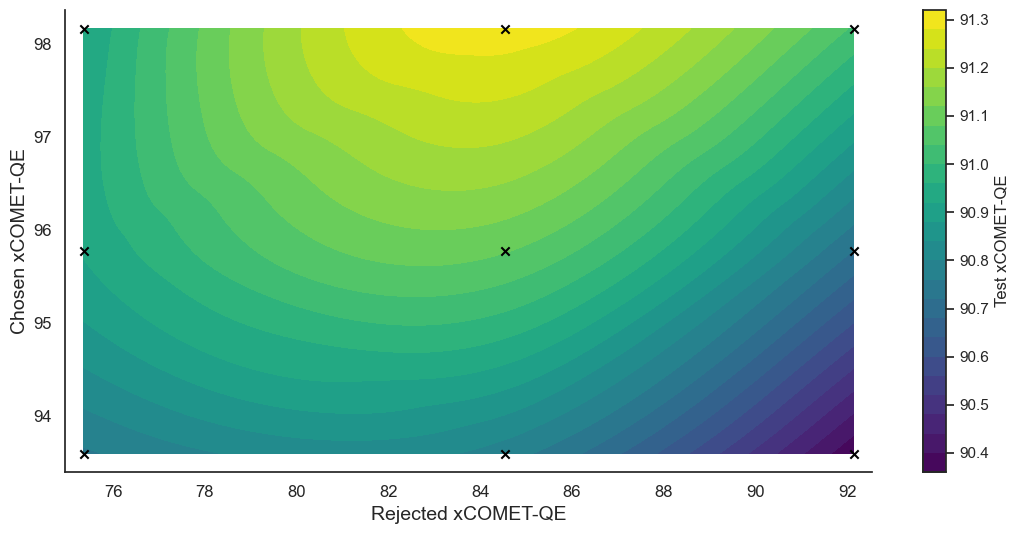

In [86]:
# Collect data
df = pd.DataFrame()
for sys in tqdm(plot_info["systems"]):
    pref_data_name = f"ALMA-Preference-{sys[sys.find('-')+1:]}"
    pref_df = load_dataset(f"hgissbkh/{pref_data_name}")["train"].to_pandas()
    rej_metric = pref_df[f"rejected_{metrics_dict[plot_info['metric']]}"].mean()
    chos_metric = pref_df[f"chosen_{metrics_dict[plot_info['metric']]}"].mean()
    df.loc[chos_metric, rej_metric] = wmt22_df[f"{models_dict[sys]['short_name']}_{metrics_dict[plot_info['metric']]}"].mean()

# Interpolate data
x1 = np.array(list(df.columns))
x2 = np.array(list(df.index))
f = df.values
x1_grid, x2_grid = np.meshgrid(x1, x2)
points = np.array([x1_grid.flatten(), x2_grid.flatten()]).T
values = f.flatten()
x1_new = np.linspace(x1.min(), x1.max(), 100)
x2_new = np.linspace(x2.min(), x2.max(), 100)
x1_new_grid, x2_new_grid = np.meshgrid(x1_new, x2_new)
f_new = griddata(points, values, (x1_new_grid, x2_new_grid), method='cubic')

# Make plot
plt.figure(figsize=(11, 5.5))
sns.set(style="white")
contour = plt.contourf(x1_new_grid, x2_new_grid, f_new, levels=30, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_ticks(np.arange(90.4, 91.4, 0.1))
cbar.set_label(f"Test {plot_info['metric']}")
for chos in x2:
    for rej in x1:        
        plt.scatter(rej, chos, color="black", marker="x")
plt.xlabel(f"Rejected {plot_info['metric']}", fontsize=14)
plt.ylabel(f"Chosen {plot_info['metric']}", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(df.columns.min() - 0.4, df.columns.max() + 0.4)
plt.ylim(df.index.min() - 0.2, df.index.max() + 0.2)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/qual_study_raw.pdf", bbox_inches='tight')
plt.show()

# Appendix

## Tables 5, 6, 7, 8

Execute code from Tables 1, 2, 3, 4 and replace `wmt22_df` by `wmt23_df`.

## Table 9

In [87]:
table_info = {
    "setting": "Multi",
    "systems": [
        'SFT-Multi-xCOMET-QE',
        'SFT-Multi-No-Ref-xCOMET-QE',
        'SFT-Multi-No-Base-xCOMET-QE',
        'SFT-Multi-No-GPT-4-xCOMET-QE',
        'SFT-Multi-xCOMET-QE-Choose-Base',
        'SFT-Multi-xCOMET-QE-Choose-GPT-4',
        'SFT-Multi-xCOMET-QE-Choose-Ref',
        'SFT-Multi-CometKiwi',
        'SFT-Multi-chrF',
        'SFT-Multi-No-Ref-chrF',
        'SFT-Mono-xCOMET-QE',
        'CPO-Multi-xCOMET-QE',
        'CPO-Multi-No-Ref-xCOMET-QE',
        'CPO-Multi-No-Base-xCOMET-QE',
        'CPO-Multi-No-GPT-4-xCOMET-QE',
        'CPO-Multi-xCOMET-QE-Choose-Base',
        'CPO-Multi-xCOMET-QE-Choose-GPT-4',
        'CPO-Multi-xCOMET-QE-Choose-Ref',
        'CPO-Multi-CometKiwi',
        'CPO-Multi-chrF',
        'CPO-Multi-No-Ref-chrF',
        'CPO-Mono-xCOMET-QE',
        'CPO-Mono-xCOMET-QE-Optimized'
    ],
    "lang_pairs": ["cs-en", "en-cs", "de-en", "en-de", "is-en", "en-is", "ru-en", "en-ru", "zh-en", "en-zh", "xx-en", "en-xx"],
    "neural_metrics": ["xCOMET-QE", "CometKiwi", "Metric-X"],
    "lexical_metrics": ["chrF", "BLEU"]
}

In [88]:
df = make_table_eval(wmt22_df, table_info)
df

cs-en                                    \
                                     Neural                           Lexical   
                                  xCOMET-QE  CometKiwi  Metric-X         chrF   
Base                              83.424095  82.568772  2.004189    65.813957   
SFT-Multi-xCOMET-QE               86.175248  83.174234  1.980319    67.355127   
SFT-Multi-No-Ref-xCOMET-QE         86.43061  83.201253  1.973691    67.498872   
SFT-Multi-No-Base-xCOMET-QE       86.576046  83.011328  1.992252    67.790604   
SFT-Multi-No-GPT-4-xCOMET-QE      85.234654  83.030182  2.020156    66.553134   
SFT-Multi-xCOMET-QE-Choose-Base   84.637195  82.868123  2.034477    66.392401   
SFT-Multi-xCOMET-QE-Choose-GPT-4  86.969026  82.688128  1.996704    67.616358   
SFT-Multi-xCOMET-QE-Choose-Ref    83.778402  82.829622  2.039558    65.738656   
SFT-Multi-CometKiwi               86.165793  83.313566  1.967714    67.500735   
SFT-Multi-chrF                    83.628135  82.851313  2.060069    65.223724   
SFT-Multi-No-Ref-chrF             86.150225  82.908158  1.987711     67.66598   
SFT-Mono-xCOMET-QE                84.997445  83.114586  1.992833    66.382834   
CPO-Multi-xCOMET-QE               87.399289  83.579098  1.944257    67.524681   
CPO-Multi-No-Ref-xCOMET-QE        87.589428  83.178466  1.951359    67.901247   
CPO-Multi-No-Base-xCOMET-QE       86.679565   83.21545  1.962965    67.456638   
CPO-Multi-No-GPT-4-xCOMET-QE      84.947404  83.219682  1.985323    65.989625   
CPO-Multi-xCOMET-QE-Choose-Base   84.102809  82.694291  2.052384    65.941646   
CPO-Multi-xCOMET-QE-Choose-GPT-4  87.704448  81.765258  2.065754    66.722855   
CPO-Multi-xCOMET-QE-Choose-Ref    71.817187  79.561973  2.218718    54.770428   
CPO-Multi-CometKiwi                86.74449  83.464809  1.947157    67.672425   
CPO-Multi-chrF                    66.307683  76.409684  2.525658    51.025181   
CPO-Multi-No-Ref-chrF             86.649337  82.985624  1.983363    68.328994   
CPO-Mono-xCOMET-QE                85.992698  83.655266   1.92503    67.101803   
CPO-Mono-xCOMET-QE-Optimized      86.513787  83.840926    1.9029    67.076692   

                                                   en-cs                       \
                                                  Neural                        
                                       BLEU    xCOMET-QE  CometKiwi  Metric-X   
Base                              41.250999    90.801975  81.961328   1.47501   
SFT-Multi-xCOMET-QE               42.813589    91.491418   82.68687  1.415877   
SFT-Multi-No-Ref-xCOMET-QE        42.928127    91.276314  82.099422   1.44987   
SFT-Multi-No-Base-xCOMET-QE       42.993011    91.611551  82.627423  1.415478   
SFT-Multi-No-GPT-4-xCOMET-QE      42.213142    91.533527  82.777803  1.415444   
SFT-Multi-xCOMET-QE-Choose-Base   41.988823    90.774919  81.686301   1.50137   
SFT-Multi-xCOMET-QE-Choose-GPT-4  41.988259    91.143865   81.32788   1.48249   
SFT-Multi-xCOMET-QE-Choose-Ref    41.615274    91.358154  82.646084  1.402604   
SFT-Multi-CometKiwi               43.077834    91.572041  83.005535  1.403617   
SFT-Multi-chrF                    40.773006     91.41684  82.447799  1.406653   
SFT-Multi-No-Ref-chrF             43.225325    91.291547  81.852178  1.477454   
SFT-Mono-xCOMET-QE                41.805946    91.035503  82.228181  1.452334   
CPO-Multi-xCOMET-QE                42.53534    90.863399  84.581603  1.395413   
CPO-Multi-No-Ref-xCOMET-QE        41.862106     91.59725  82.632816  1.406304   
CPO-Multi-No-Base-xCOMET-QE        42.84005    90.942987  84.141035  1.380333   
CPO-Multi-No-GPT-4-xCOMET-QE      41.313523    90.453588  83.906525  1.392282   
CPO-Multi-xCOMET-QE-Choose-Base   41.771466     90.42182  81.798596  1.513065   
CPO-Multi-xCOMET-QE-Choose-GPT-4  39.419991    89.732307  78.832756  1.571063   
CPO-Multi-xCOMET-QE-Choose-Ref    28.587642    79.027698  80.025707  1.594274   
CPO-Multi-CometKiwi               42.419159    90.213068  84.812212 

In [89]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll}
\toprule
 & \multicolumn{6}{r}{cs-en} &  & \multicolumn{6}{r}{en-cs} &  & \multicolumn{6}{r}{de-en} &  & \multicolumn{6}{r}{en-de} &  & \multicolumn{6}{r}{is-en} &  & \multicolumn{6}{r}{en-is} &  & \multicolumn{6}{r}{ru-en} &  & \multicolumn{6}{r}{en-ru} &  & \multicolumn{6}{r}{zh-en} &  & \multicolumn{6}{r}{en-zh} &  & \multicolumn{6}{r}{xx-en} &  & \multicolumn{6}{r}{en-xx} \\
 & \multicolumn{3}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{3}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{3}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{3}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{3}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{3}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{3}{r}{Neural} &  & \multicolumn{2}{r}{Lexical} &  & \multicolumn{3}{r}{Neural} &  & \multicolumn{2}{r}{Lexical

## Table 10

Execute code from Table 9 and replace `wmt22_df` by `wmt23_df`.

## Table 12

In [95]:
table_info = {
    "datasets": [
        "ALMA-Preference-Multi",
        "ALMA-Preference-Multi-xCOMET-QE",
        "ALMA-Preference-Mono-xCOMET-QE",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Reject-Low",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Reject-Mid",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Reject-High",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Reject-Low",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Reject-Mid",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Reject-High",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reject-Low",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reject-Mid",
        "ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reject-High",
    ],
    "lang_pairs": ["Avg."],
    "neural_metrics": ["xCOMET-QE", "CometKiwi"],
    "lexical_metrics": ["chrF"]
}

In [100]:
df = make_table_pref_data(table_info)
df

100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


Avg.  \
                                                                 Neural   
                                                              xCOMET-QE   
ALMA-Preference-Multi                              Base       93.086337   
                                                   GPT-4      94.581086   
                                                   Reference  91.838332   
ALMA-Preference-Multi-xCOMET-QE                    Rejected   87.857813   
                                                   Chosen     97.242066   
ALMA-Preference-Mono-xCOMET-QE                     Rejected   87.802609   
                                                   Chosen      97.29184   
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   75.356512   
                                                   Chosen     93.599261   
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   84.535926   
                                                   Chosen     93.599261   
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   92.146924   
                                                   Chosen     93.599261   
ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Rejec... Rejected   75.356512   
                                                   Chosen     95.768751   
ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Rejec... Rejected   84.535926   
                                                   Chosen     95.768751   
ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Rejec... Rejected   92.146924   
                                                   Chosen     95.768751   
ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reje... Rejected   75.356512   
                                                   Chosen     98.160145   
ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reje... Rejected   84.535926   
                                                   Chosen     98.160145   
ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reje... Rejected   92.146924   
                                                   Chosen     98.160145   

                                                                           \
                                                                            
                                                              CometKiwi     
ALMA-Preference-Multi                              Base       87.126533     
                                                   GPT-4      88.317363     
                                                   Reference  86.715038     
ALMA-Preference-Multi-xCOMET-QE                    Rejected   84.153573     
                                                   Chosen     89.809465     
ALMA-Preference-Mono-xCOMET-QE                     Rejected   83.044161     
                                                   Chosen     89.204829     
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   75.461873     
                                                   Chosen     87.039922     
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected   81.015484     
                                                   Chosen     87.039922     
ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Rejec... Rejected    85.54057     
                                                   Chosen     87.039922     
ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Rejec... Rejected   75.461873     
                                                   Chosen     88.401819     
ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Rejec... Rejected   81.015484     
                                                   Chosen     88.401819     
ALMA-Preference-Mono-xCOMET-QE-Choose-Mid-Rejec... Rejected    85.54057     
                                                   Chosen     88.401819     
ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reje... Rejected   75.461873     
                                                   Chosen     89.844865     
ALMA-Preference-Mono-xCOMET-QE-Choose-High-Reje... Rejected   81.015484     
                                         

In [101]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{llllll}
\toprule
 &  & \multicolumn{4}{r}{Avg.} \\
 &  & \multicolumn{2}{r}{Neural} &  & Lexical \\
 &  & xCOMET-QE & CometKiwi &  & chrF \\
\midrule
\multirow[t]{3}{*}{ALMA-Preference-Multi} & Base & 93.09 & 87.13 &  & 58.33 \\
 & GPT-4 & 94.58 & 88.32 &  & 60.93 \\
 & Reference & 91.84 & 86.72 &  & 100.00 \\
\cline{1-6}
\multirow[t]{2}{*}{ALMA-Preference-Multi-xCOMET-QE} & Rejected & 87.86 & 84.15 &  & 78.48 \\
 & Chosen & 97.24 & 89.81 &  & 75.95 \\
\cline{1-6}
\multirow[t]{2}{*}{ALMA-Preference-Mono-xCOMET-QE} & Rejected & 87.80 & 83.04 &  & 55.69 \\
 & Chosen & 97.29 & 89.20 &  & 57.18 \\
\cline{1-6}
\multirow[t]{2}{*}{ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Reject-Low} & Rejected & 75.36 & 75.46 &  & 52.95 \\
 & Chosen & 93.60 & 87.04 &  & 57.14 \\
\cline{1-6}
\multirow[t]{2}{*}{ALMA-Preference-Mono-xCOMET-QE-Choose-Low-Reject-Mid} & Rejected & 84.54 & 81.02 &  & 54.93 \\
 & Chosen & 93.60 & 87.04 &  & 57.14 \\
\cline{1-6}
\multirow[t]{2}{*}{ALMA-Preference-Mono

## Figure 2

In [102]:
plot_info = {
    "hf_data_path": "hgissbkh/ALMA-Preference-Multi",
    "colors": {
        "cs": "blue",
        "de": "orange",
        "en": "green",
        "is": "red",
        "ru": "purple",
        "zh": "brown"
    },
    "save_path": "/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/test_langs.pdf"
}

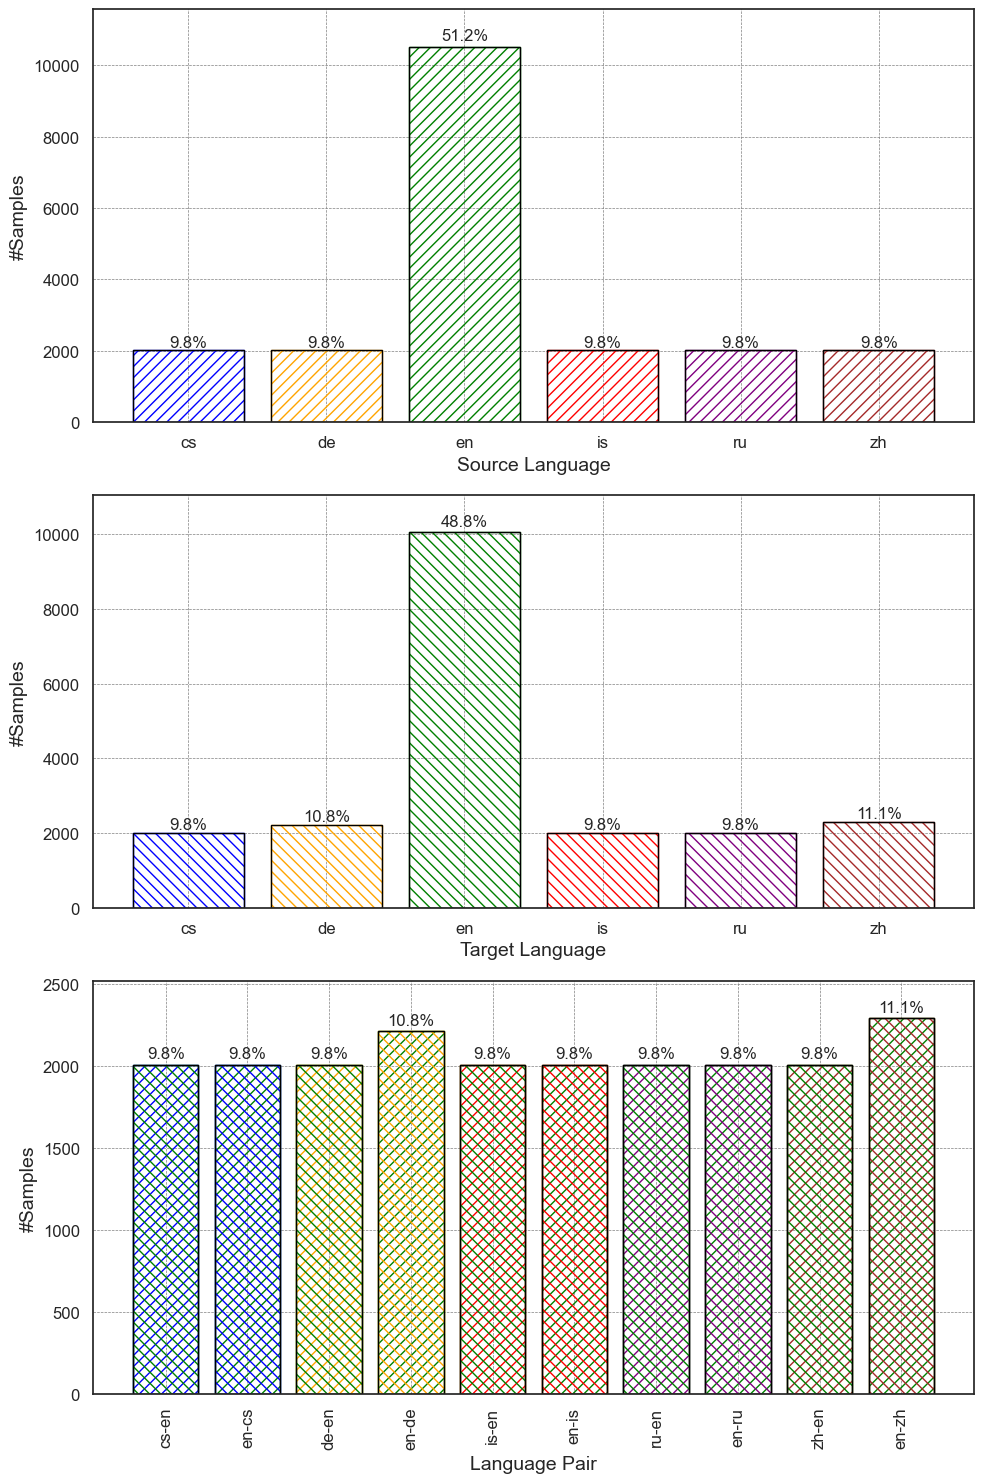

In [103]:
# Get data
ds = load_dataset("hgissbkh/ALMA-Preference-Multi")["train"].to_pandas()
count_lp = ds.groupby("lp").count().iloc[:,0][["cs-en", "en-cs", "de-en", "en-de", "is-en", "en-is", "ru-en", "en-ru", "zh-en", "en-zh"]]
count_src_lang = ds.groupby("src_lang").count().iloc[:,0]
count_tgt_lang = ds.groupby("tgt_lang").count().iloc[:,0]

# Make plot
plt.figure(figsize=(10, 15))

# Source Language Frequency
ax = plt.subplot(3, 1, 1)
for i, src_lang in enumerate(count_src_lang.index):
    ax.bar(src_lang, count_src_lang[src_lang], edgecolor=plot_info["colors"][src_lang], hatch='/'*3, facecolor='none')
    ax.bar(src_lang, count_src_lang[src_lang], edgecolor='black', facecolor='none')
    ax.text(i, count_src_lang[src_lang] + 0.01 * count_src_lang[src_lang], f'{count_src_lang[src_lang]/count_src_lang.sum()*100:.1f}%', ha='center', va='bottom')
ax.set_xlabel("Source Language", fontsize=14)
ax.set_ylabel("#Samples", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 1.1*count_src_lang.max())
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Target Language Frequency
ax = plt.subplot(3, 1, 2)
for i, tgt_lang in enumerate(count_tgt_lang.index):
    ax.bar(tgt_lang, count_tgt_lang[tgt_lang], edgecolor=plot_info["colors"][tgt_lang], hatch='\\'*3, facecolor='none')
    ax.bar(tgt_lang, count_tgt_lang[tgt_lang], edgecolor='black', facecolor='none')
    ax.text(i, count_tgt_lang[tgt_lang] + 0.01 * count_tgt_lang[tgt_lang], f'{count_tgt_lang[tgt_lang]/count_tgt_lang.sum()*100:.1f}%', ha='center', va='bottom')
ax.set_xlabel("Target Language", fontsize=14)
ax.set_ylabel("#Samples", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 1.1*count_tgt_lang.max())
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Language Pair Frequency
ax = plt.subplot(3, 1, 3)
for i, lp in enumerate(count_lp.index):
    src_lang, tgt_lang = lp.split("-")
    ax.bar(lp, count_lp[lp], edgecolor=plot_info["colors"][src_lang], hatch='/'*3, facecolor='none')
    ax.bar(lp, count_lp[lp], edgecolor=plot_info["colors"][tgt_lang], hatch='\\'*3, facecolor='none')
    ax.bar(lp, count_lp[lp], edgecolor='black', facecolor='none')
    ax.text(i, count_lp[lp] + 0.01 * count_lp[lp], f'{count_lp[lp]/count_lp.sum()*100:.1f}%', ha='center', va='bottom')
ax.set_xlabel("Language Pair", fontsize=14)
ax.set_ylabel("#Samples", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 1.1*count_lp.max())
ax.set_xticklabels(count_lp.index, rotation=90)
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
# plt.savefig(plot_info["save_path"])
plt.show()

## Figure 3

In [104]:
plot_info = {
    "colors": {
        "cs": "blue",
        "de": "orange",
        "en": "green",
        "is": "red",
        "ru": "purple",
        "zh": "brown"
    },
    "save_path": "/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/test_langs.pdf"
}

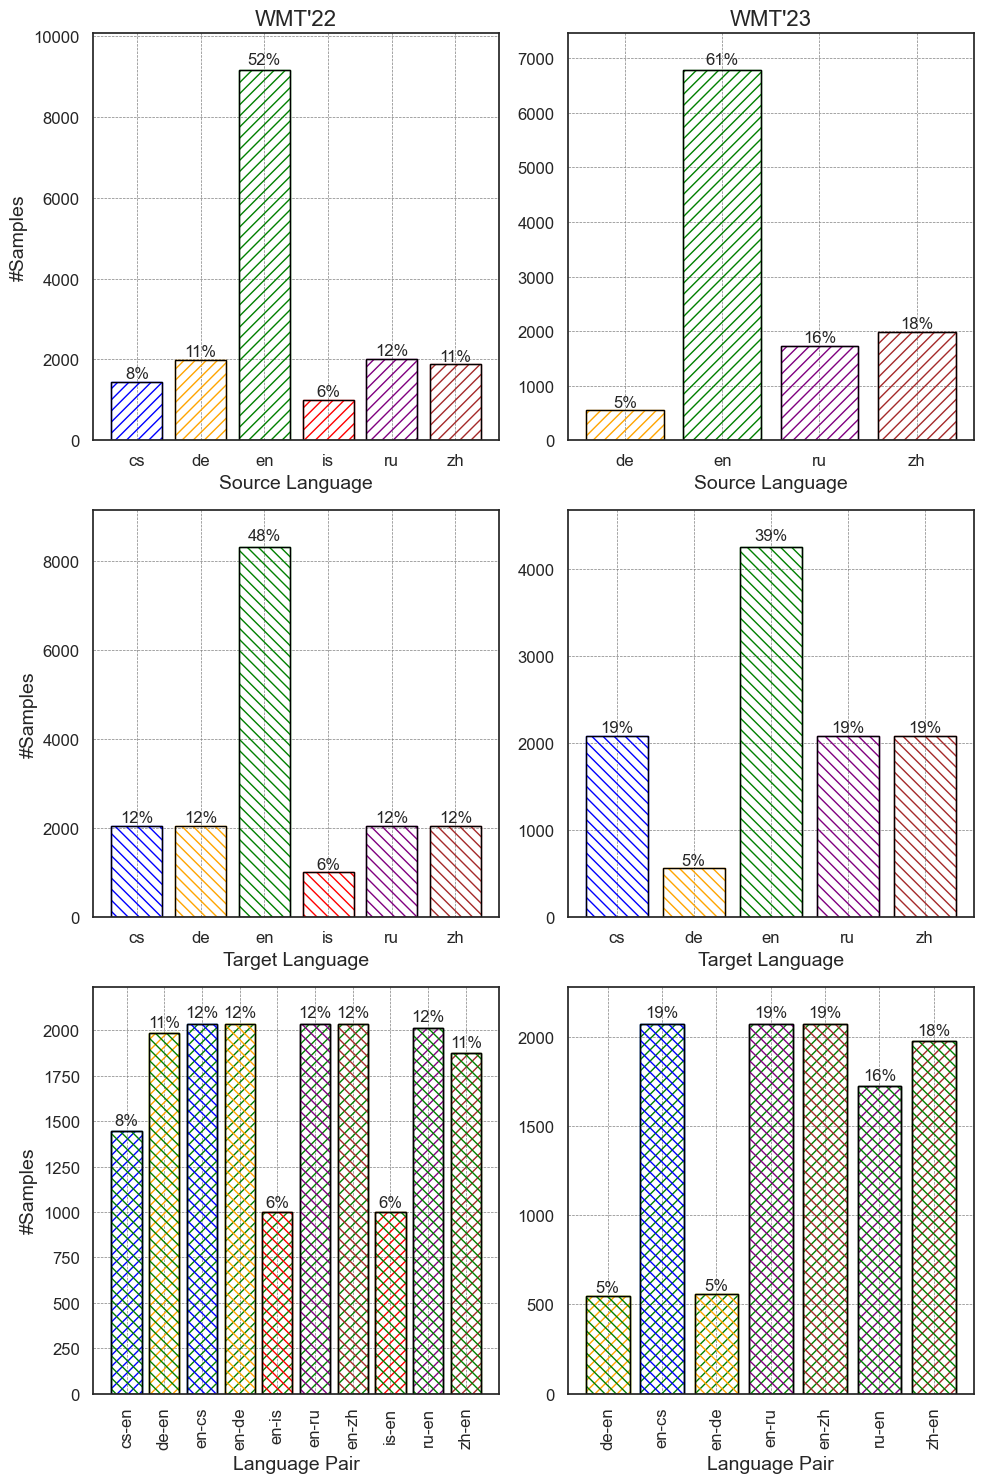

In [105]:
# Make plot
plt.figure(figsize=(10, 15))

for k, ds in enumerate([wmt22_df, wmt23_df]):
    if k == 0:
        subplot_indices = [1, 3, 5]
    if k == 1:
        subplot_indices = [2, 4, 6]
    count_lp = ds.groupby("lp").count().iloc[:,0]
    count_src_lang = ds.groupby("src_lang").count().iloc[:,0]
    count_tgt_lang = ds.groupby("tgt_lang").count().iloc[:,0]

    # Source Language Frequency
    ax = plt.subplot(3, 2, subplot_indices[0])
    for i, src_lang in enumerate(count_src_lang.index):
        ax.bar(src_lang, count_src_lang[src_lang], edgecolor=plot_info["colors"][src_lang], hatch='/'*3, facecolor='none')
        ax.bar(src_lang, count_src_lang[src_lang], edgecolor='black', facecolor='none')
        ax.text(i, count_src_lang[src_lang] + 0.01 * count_src_lang[src_lang], f'{count_src_lang[src_lang]/count_src_lang.sum()*100:.0f}%', ha='center', va='bottom')
    ax.set_xlabel("Source Language", fontsize=14)
    if k == 0:
        ax.set_ylabel("#Samples", fontsize=14)
    ax.tick_params(labelsize=12)
    ax.set_ylim(0, 1.1*count_src_lang.max())
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
    if k == 0:
        ax.set_title("WMT'22", fontsize=16)
    if k == 1:
        ax.set_title("WMT'23", fontsize=16)

    # Target Language Frequency
    ax = plt.subplot(3, 2, subplot_indices[1])
    for i, tgt_lang in enumerate(count_tgt_lang.index):
        ax.bar(tgt_lang, count_tgt_lang[tgt_lang], edgecolor=plot_info["colors"][tgt_lang], hatch='\\'*3, facecolor='none')
        ax.bar(tgt_lang, count_tgt_lang[tgt_lang], edgecolor='black', facecolor='none')
        ax.text(i, count_tgt_lang[tgt_lang] + 0.01 * count_tgt_lang[tgt_lang], f'{count_tgt_lang[tgt_lang]/count_tgt_lang.sum()*100:.0f}%', ha='center', va='bottom')
    ax.set_xlabel("Target Language", fontsize=14)
    if k == 0:
        ax.set_ylabel("#Samples", fontsize=14)
    ax.tick_params(labelsize=12)
    ax.set_ylim(0, 1.1*count_tgt_lang.max())
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

    # Language Pair Frequency
    ax = plt.subplot(3, 2, subplot_indices[2])
    for i, lp in enumerate(count_lp.index):
        src_lang, tgt_lang = lp.split("-")
        ax.bar(lp, count_lp[lp], edgecolor=plot_info["colors"][src_lang], hatch='/'*3, facecolor='none')
        ax.bar(lp, count_lp[lp], edgecolor=plot_info["colors"][tgt_lang], hatch='\\'*3, facecolor='none')
        ax.bar(lp, count_lp[lp], edgecolor='black', facecolor='none')
        ax.text(i, count_lp[lp] + 0.01 * count_lp[lp], f'{count_lp[lp]/count_lp.sum()*100:.0f}%', ha='center', va='bottom')
    ax.set_xlabel("Language Pair", fontsize=14)
    if k == 0:
        ax.set_ylabel("#Samples", fontsize=14)
    ax.tick_params(labelsize=12)
    ax.set_ylim(0, 1.1*count_lp.max())
    ax.set_xticklabels(count_lp.index, rotation=90)
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(plot_info["save_path"])
plt.show()